In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import math
from scipy import stats
from sklearn import preprocessing
import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import re
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
import nltk
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.filterwarnings('ignore')
from scipy.io import loadmat
import os
from scipy.optimize import fmin_cg
import scipy.io as si

In [2]:
spend = pd.read_csv('spend_data.csv', parse_dates=['date'])

In [3]:
spend=pd.DataFrame(spend)

In [4]:
spend.drop(spend.columns[0], axis=1, inplace=True)
spend.head()

,date,campaign,spend
0,2020-05-24,facebook_5_B,17.0238
1,2020-05-24,facebook_5_D,1.7034
2,2020-05-24,instagram_5_B,14.8920
3,2020-05-24,instagram_5_D,1.6116
4,2020-05-25,facebook_5_B,22.6644


In [5]:
trials = pd.read_csv('trials_data.csv', parse_dates=['date'])

In [6]:
trials=pd.DataFrame(trials)

In [7]:
trials.drop(trials.columns[0], axis=1, inplace=True)
trials.head(10)

,date,trials
0,2020-05-01,0.0
1,2020-05-02,0.0
2,2020-05-03,0.0
3,2020-05-04,0.0
4,2020-05-05,0.0
5,2020-05-06,0.0
6,2020-05-07,0.0
7,2020-05-08,0.0
8,2020-05-09,0.0
9,2020-05-10,0.0


### Merging two data

In [8]:
data=pd.merge(trials,spend,on='date')
data.head()

,date,trials,campaign,spend
0,2020-05-24,0.0,facebook_5_B,17.0238
1,2020-05-24,0.0,facebook_5_D,1.7034
2,2020-05-24,0.0,instagram_5_B,14.8920
3,2020-05-24,0.0,instagram_5_D,1.6116
4,2020-05-25,1.0,facebook_5_B,22.6644


# 1- Data  exploration
## 1-1 General intuition of data

In [9]:
# total number of trials happend over whole period of time
data['trials'].sum()

598437.0

In [10]:
# total amount of money spent over whole period of time
data['spend'].sum()

1635002.2076098802

<AxesSubplot:xlabel='date'>

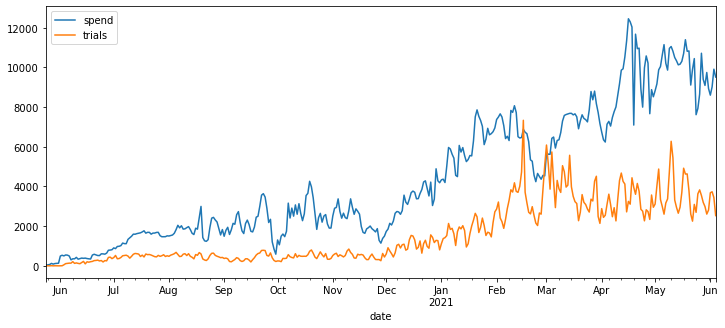

In [11]:
# first let us look at the histroy of spending money and trials over the time (we groupby the date)
# it seems the client has increased the spending over last couple of months, however, the number of trials remained almost constant. So the strategy of 
#allocating was not efficient. 
data.groupby(by='date').sum()[['spend','trials']].plot(figsize=(12, 5))

In [12]:
# clients mostly invested on facebook_1_A
spend.groupby(by='campaign').sum().sort_values(by='spend')

,spend
campaign,
facebook_5_A,9052.510200
apple_5_A,11395.297200
instagram_1_D,11892.162164
facebook_1_D,12206.690645
instagram_5_D,37174.075102
facebook_5_D,55673.730102
apple_1_A,66856.073400
apple_4_D,87203.053800
instagram_5_B,90357.940736


In [13]:
# the client got the highest trials from facebook_2_C
data.groupby(by='campaign').sum()[['trials']].sort_values(by='trials')

,trials
campaign,
apple_5_A,15342.0
facebook_5_B,18076.0
instagram_5_B,18076.0
instagram_5_D,18076.0
apple_1_A,19495.0
facebook_5_D,20026.0
facebook_5_A,22274.0
facebook_3_A,31528.0
facebook_1_D,49936.0


<AxesSubplot:ylabel='Frequency'>

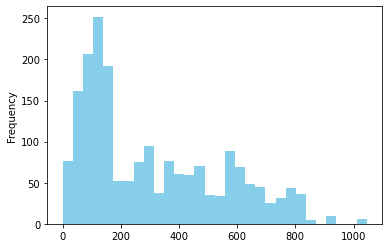

In [14]:
# tirals around 0-200 occured more often
data['trials'].plot.hist(bins=30,color = "skyblue")

<AxesSubplot:ylabel='Frequency'>

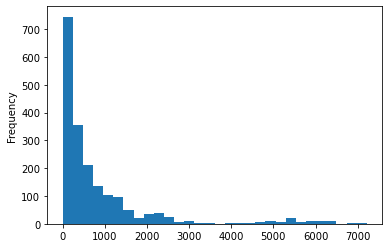

In [15]:
# the most occured amount of spend money on campaigns are around 0-500 $
data['spend'].plot.hist(bins=30)

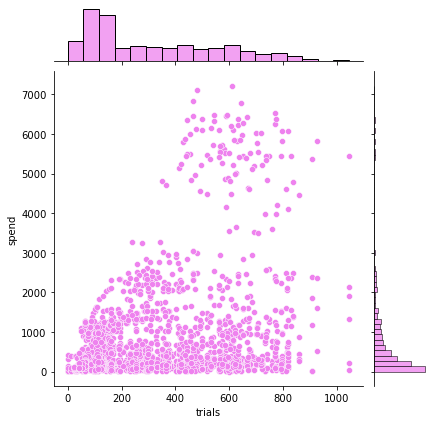

In [16]:
# this jointplot indicates that for high spending  the number of trials tend to increase. which is natural
sns.jointplot(x='trials',y='spend',data=data, color='violet')

## 1-2 Intuition about different netwrok, different target_type and different audiance type

In [17]:
# here we separet different targets. so split each campain by its target type and audiance type.
data_separated_targets = data.assign(Target_audiance =data['campaign'].str[-1:], Target_type =data['campaign'].str[-3:-2])

In [18]:
data_separated_targets.head()

,date,trials,campaign,spend,Target_audiance,Target_type
0,2020-05-24,0.0,facebook_5_B,17.0238,B,5
1,2020-05-24,0.0,facebook_5_D,1.7034,D,5
2,2020-05-24,0.0,instagram_5_B,14.8920,B,5
3,2020-05-24,0.0,instagram_5_D,1.6116,D,5
4,2020-05-25,1.0,facebook_5_B,22.6644,B,5


In [19]:
#replace the campain with network.
data_separated_targets  = data_separated_targets.assign(campaign =data['campaign'].str[:-4])

In [20]:
data_separated_targets.head()

,date,trials,campaign,spend,Target_audiance,Target_type
0,2020-05-24,0.0,facebook,17.0238,B,5
1,2020-05-24,0.0,facebook,1.7034,D,5
2,2020-05-24,0.0,instagram,14.8920,B,5
3,2020-05-24,0.0,instagram,1.6116,D,5
4,2020-05-25,1.0,facebook,22.6644,B,5


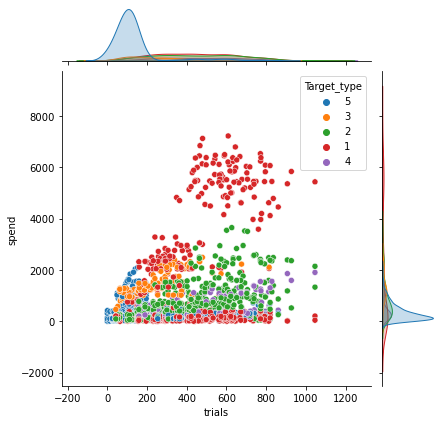

In [21]:
# this separation over target_types indicates that we might have more efficient on campaigns with 
# target_type 1  and 5 (down red  and blue points) which spend less money.
# 1,2,..5 in the plot are target types.
sns.jointplot(x='trials',y='spend',data=data_separated_targets ,hue='Target_type')

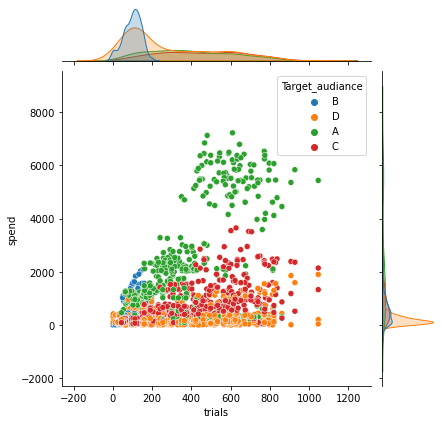

In [22]:
# following plot indicates that the audiancese group D and A shows less spending (orange and green points on bottom 
# points with minimum spending) for even high trials. 
sns.jointplot(x='trials',y='spend',data=data_separated_targets ,hue='Target_audiance')

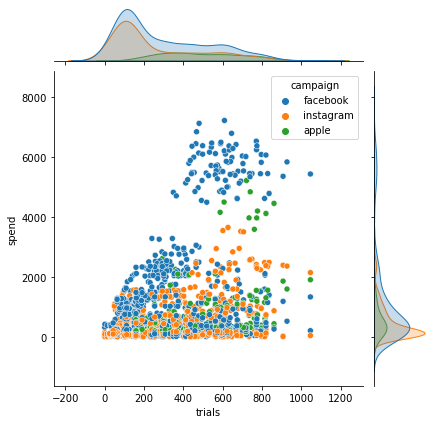

In [23]:
# this plot actually does not indicate which netwrok givs better spend, becuase we see that all 3 colors are present
# in the small spending regions.
sns.jointplot(x='trials',y='spend',data=data_separated_targets ,hue='campaign')

## 1-3 Investigating all 14 campaigns to see which ones are most efficient

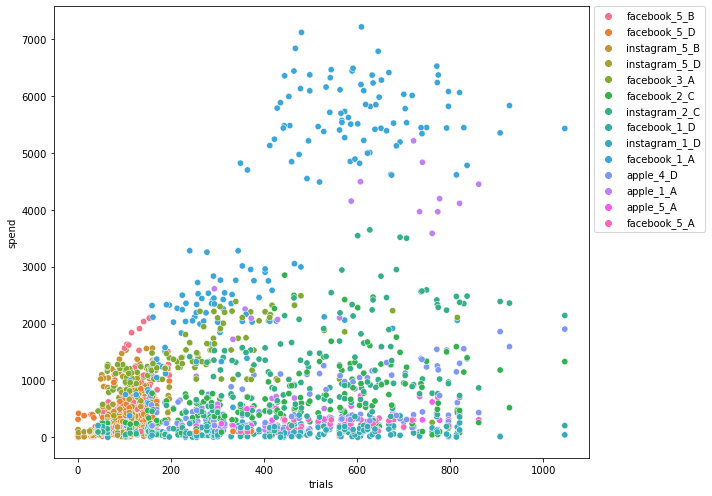

In [24]:
# the following scatter plot shows the money spent and the number of trails for each campaign. In the first glance
# we can see the colors related to points instagram_1_D or facebook_1_D has higher trials while spending less 
# money --> so, more efficient
plt.figure(figsize=(10,7))
sns.scatterplot(data=data,x='trials',y='spend',hue="campaign",s=40 )


plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.tight_layout()

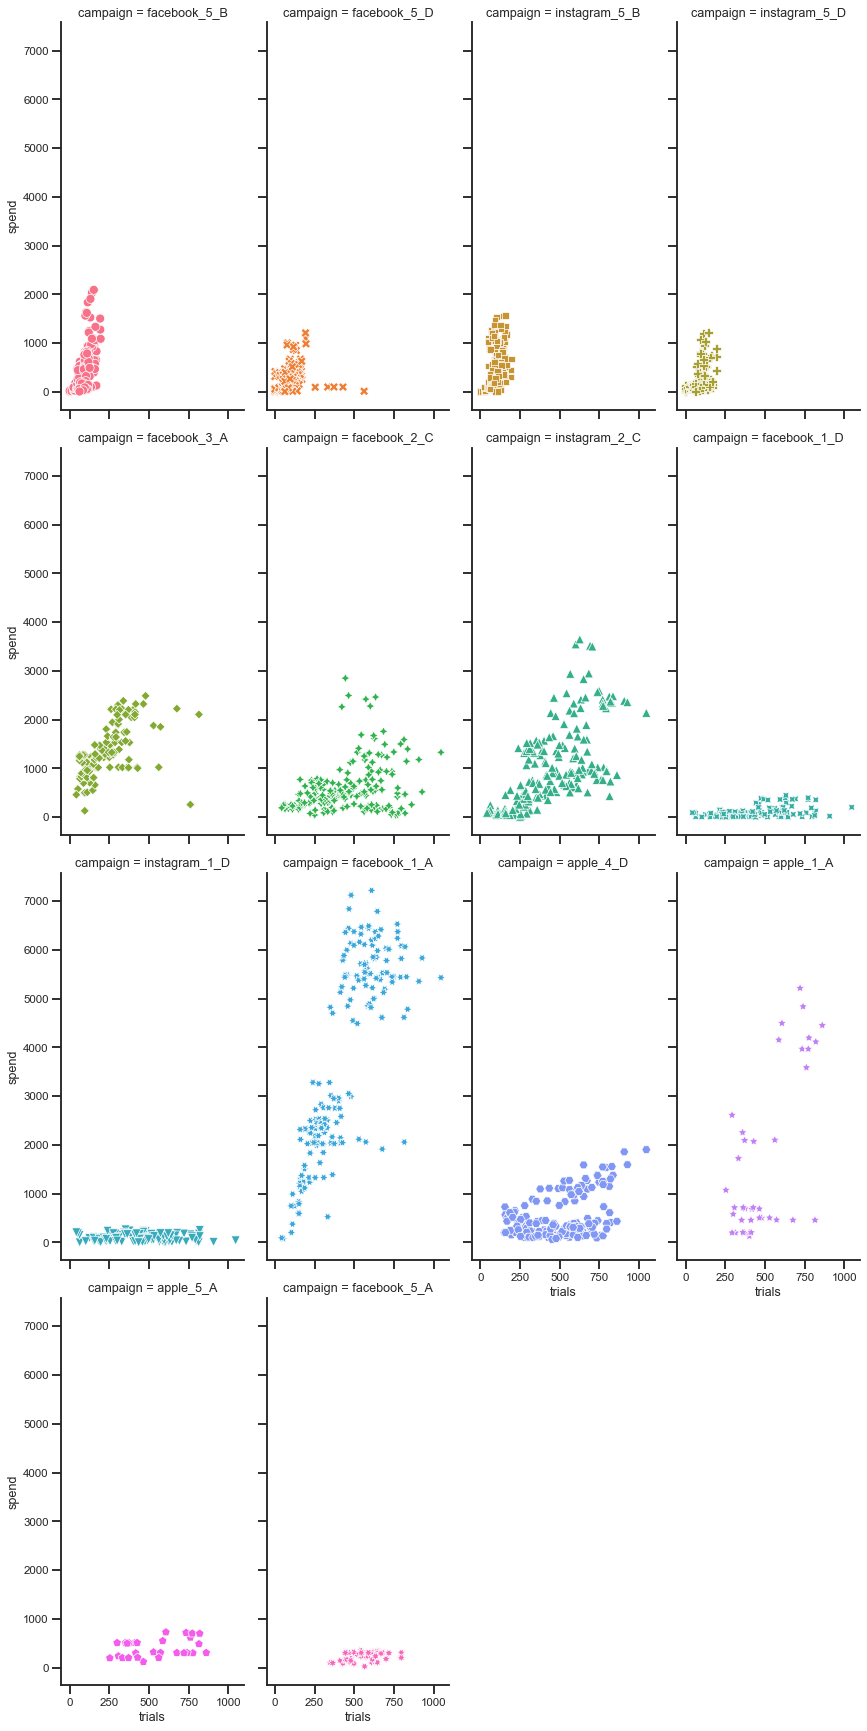

In [25]:
# in order to better see the latter outcome, we vitualize all 14 campaigns. 
# these plots confirm that the best is instagram_1_D and facebook_1_D.
sns.set(rc={'figure.figsize':(40,40)}) 
sns.set_context('talk', font_scale=0.7) 
sns.set_style('ticks')
g = sns.relplot(data=data,x='trials',y='spend',hue="campaign",col="campaign",col_wrap=4,legend=False,height=6, 
                aspect=0.5, style='campaign', sizes=(500,400))


### In the table, we separate campaigns to better data analysis

In [26]:
dummies=['campaign']

In [27]:
dummed_data= pd.get_dummies(data,columns=dummies)

In [28]:
dummed_data.head()

,date,trials,spend,campaign_apple_1_A,campaign_apple_4_D,campaign_apple_5_A,campaign_facebook_1_A,campaign_facebook_1_D,campaign_facebook_2_C,campaign_facebook_3_A,campaign_facebook_5_A,campaign_facebook_5_B,campaign_facebook_5_D,campaign_instagram_1_D,campaign_instagram_2_C,campaign_instagram_5_B,campaign_instagram_5_D
0,2020-05-24,0.0,17.0238,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2020-05-24,0.0,1.7034,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2020-05-24,0.0,14.8920,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2020-05-24,0.0,1.6116,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2020-05-25,1.0,22.6644,0,0,0,0,0,0,0,0,1,0,0,0,0,0


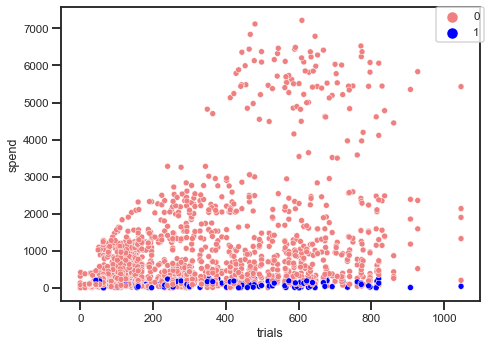

In [29]:
# In this plot we see that when there was campaign instagram_1_D they spent much less than when they had other campaigns. 
# 0 (pink color) means there was no campaign 'instagram_1_D', while the 1 (blue color)  means there was no instagram_1_D.

plt.figure(figsize=(7,5))
sns.scatterplot(x='trials',y='spend',
                hue="campaign_instagram_1_D",s=35,palette=['lightcoral','blue'],
                data=dummed_data)
# place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.tight_layout()

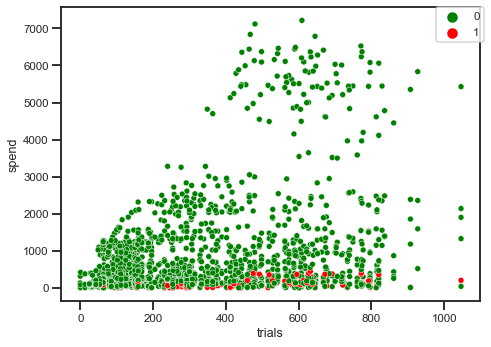

In [30]:
# 0 means there was no "campaign_facebook_1_D" campaign, while 1 means there was "campaign_facebook_1_D".
plt.figure(figsize=(7,5))
sns.scatterplot(x='trials',y='spend',
                hue="campaign_facebook_1_D",s=35,data=dummed_data,palette=['green','red'],)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.tight_layout()

In [31]:
# we groupby date
# the following plot indicates that spending more money does not nessesarely means having more trials. there are points
# with high trials but less spending. Such as points in (~7000 trials,~6000 spend) or  (~6000 trials,~6000 spend)
grouped_data= dummed_data.groupby("date", as_index=False)[dummed_data.columns].sum()
grouped_data.head()

,date,trials,spend,campaign_apple_1_A,campaign_apple_4_D,campaign_apple_5_A,campaign_facebook_1_A,campaign_facebook_1_D,campaign_facebook_2_C,campaign_facebook_3_A,campaign_facebook_5_A,campaign_facebook_5_B,campaign_facebook_5_D,campaign_instagram_1_D,campaign_instagram_2_C,campaign_instagram_5_B,campaign_instagram_5_D
0,2020-05-24,0.0,35.230800,0,0,0,0,0,0,0,0,1,1,0,0,1,1
1,2020-05-25,4.0,49.969800,0,0,0,0,0,0,0,0,1,1,0,0,1,1
2,2020-05-26,0.0,65.688000,0,0,0,0,0,0,0,0,1,1,0,0,1,1
3,2020-05-27,8.0,123.032400,0,0,0,0,0,0,0,0,1,1,0,0,1,1
4,2020-05-28,0.0,87.424214,0,0,0,0,0,0,0,0,1,1,0,0,1,1


Text(0, 0.5, 'spend')

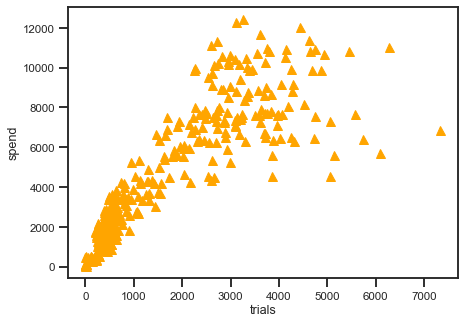

In [32]:
plt.figure(figsize=(7,5))
plt.plot(grouped_data['trials'],grouped_data['spend'],'r^',
         color='orange',  lw=3)
plt.xlabel('trials')
plt.ylabel('spend')


## 1-4 Weekday analysis

In [33]:
# for each day we show which day of the week it is
data['day_of_week'] = data['date'].dt.day_name()

In [34]:
data.head()

,date,trials,campaign,spend,day_of_week
0,2020-05-24,0.0,facebook_5_B,17.0238,Sunday
1,2020-05-24,0.0,facebook_5_D,1.7034,Sunday
2,2020-05-24,0.0,instagram_5_B,14.8920,Sunday
3,2020-05-24,0.0,instagram_5_D,1.6116,Sunday
4,2020-05-25,1.0,facebook_5_B,22.6644,Monday


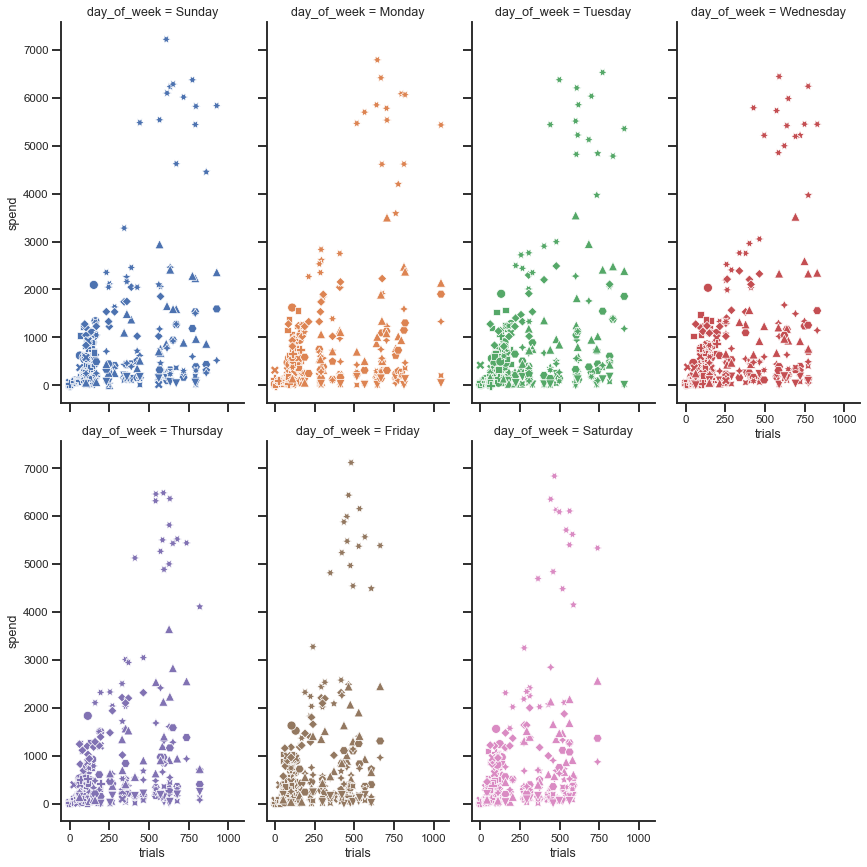

In [35]:
#It seems that people downloaded the trials more often on Mondays and Sundays. The less downloaded day is Friday. However
# for finding the exact result furture investigation is nessesary. With fix spending.

sns.set(rc={'figure.figsize':(40,40)}) 
sns.set_context('talk', font_scale=0.7) 
sns.set_style('ticks')
g = sns.relplot(data=data,x='trials',y='spend',hue="day_of_week",col="day_of_week",col_wrap=4,legend=False,height=6, 
                aspect=0.5, style='campaign', sizes=(500,400))


# Exact retuls: Lets calculate the number of trials for given 100 dollors for each campaigns

In [36]:
# first obtain the total spent money and total trials for each campaign.
campaign_trials=data.groupby(by='campaign').sum()[['spend','trials']].sort_values(by='spend',ascending=False)
campaign_trials

,spend,trials
campaign,,
facebook_1_A,662534.318977,77639.0
instagram_2_C,196848.400901,86197.0
facebook_3_A,181740.999000,31528.0
facebook_2_C,115737.396794,86419.0
facebook_5_B,96329.558588,18076.0
instagram_5_B,90357.940736,18076.0
apple_4_D,87203.053800,85417.0
apple_1_A,66856.073400,19495.0
facebook_5_D,55673.730102,20026.0


In [37]:
# now we assign 100 $ for all campaigns and obtain trials for each of them for the invested money.
campaign_trials = campaign_trials.assign(percent=campaign_trials['trials']*100/campaign_trials['spend'])

In [38]:
# to better see the result we sort by higher percentenge of the trials
# As seen 'instagram_1_D' gives higher trials for given 100$. This is same result as observed in data analysis.
campaign_trials.groupby(by='campaign').sum().sort_values(by='percent', ascending=False)

,spend,trials,percent
campaign,,,
instagram_1_D,11892.162164,49936.0,419.906820
facebook_1_D,12206.690645,49936.0,409.087126
facebook_5_A,9052.510200,22274.0,246.053299
apple_5_A,11395.297200,15342.0,134.634488
apple_4_D,87203.053800,85417.0,97.951845
facebook_2_C,115737.396794,86419.0,74.668173
instagram_5_D,37174.075102,18076.0,48.625285
instagram_2_C,196848.400901,86197.0,43.788519
facebook_5_D,55673.730102,20026.0,35.970286


### Conclution:
### from last table is instagram_1_D  is the  most efficient campaign which gives higher trials for given money. 
### The result perfectly is in line with data analysis obtained earlier.